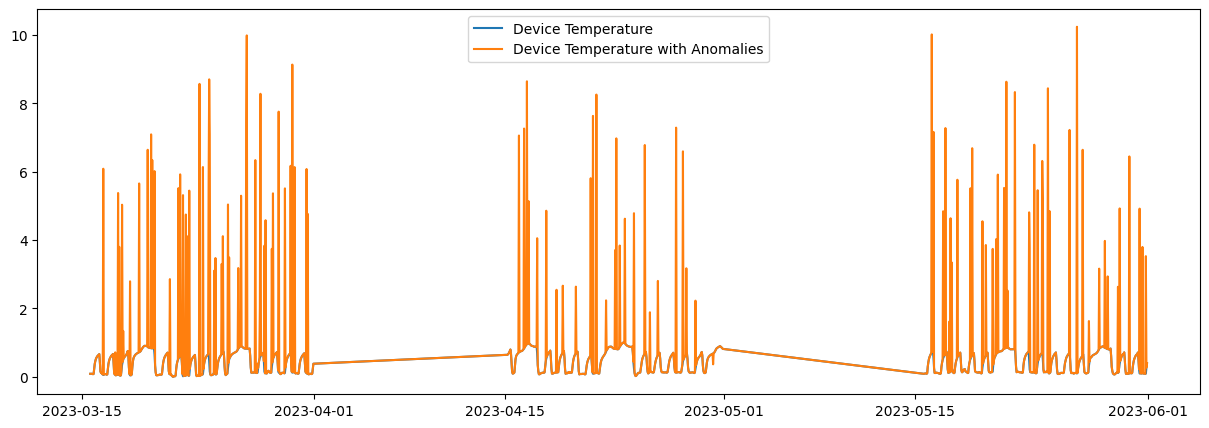

Epoch 1/20
12/12 [==============================] - 1s 12ms/step - loss: 3.2019 - val_loss: 3.3308
Epoch 2/20
12/12 [==============================] - 0s 4ms/step - loss: 3.0003 - val_loss: 3.1129
Epoch 3/20
12/12 [==============================] - 0s 3ms/step - loss: 2.8270 - val_loss: 2.9212
Epoch 4/20
12/12 [==============================] - 0s 3ms/step - loss: 2.6123 - val_loss: 2.6435
Epoch 5/20
12/12 [==============================] - 0s 3ms/step - loss: 2.2444 - val_loss: 2.0346
Epoch 6/20
12/12 [==============================] - 0s 3ms/step - loss: 1.5603 - val_loss: 1.0238
Epoch 7/20
12/12 [==============================] - 0s 2ms/step - loss: 0.5441 - val_loss: 0.2518
Epoch 8/20
12/12 [==============================] - 0s 3ms/step - loss: 0.2443 - val_loss: 0.1912
Epoch 9/20
12/12 [==============================] - 0s 2ms/step - loss: 0.1931 - val_loss: 0.1744
Epoch 10/20
12/12 [==============================] - 0s 2ms/step - loss: 0.1586 - val_loss: 0.1374
Epoch 11/20
12/12 

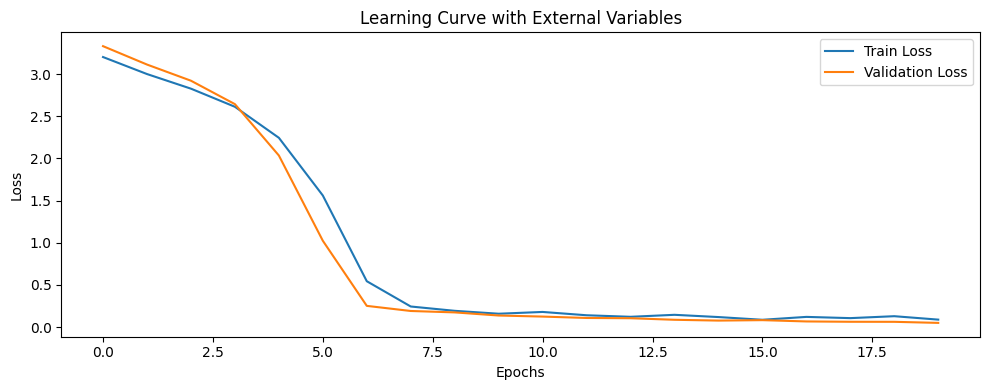

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import joblib

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
file_path = 'baseline_data.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')

# Check for missing values and fill if any
df.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']] = scaler.fit_transform(
    df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']]
)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Feature engineering
df['temp_diff'] = df['device_temperature'] - df['climate_temperature']
df['humidity_diff'] = df['device_humidity'] - df['climate_humidity']
df['hour_of_day'] = df.index.hour

# Function to add synthetic anomalies
def add_synthetic_anomalies(df, anomaly_fraction=0.1, seed=42):
    np.random.seed(seed)
    df_with_anomalies = df.copy()
    num_anomalies = int(len(df) * anomaly_fraction)
    anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)
    df_with_anomalies.loc[anomaly_indices, 'device_temperature'] += np.random.normal(5, 2, size=num_anomalies)
    df_with_anomalies['label'] = 1
    df_with_anomalies.loc[anomaly_indices, 'label'] = -1
    return df_with_anomalies

# Add synthetic anomalies
df_with_anomalies = add_synthetic_anomalies(df)

# Visualize the data
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['device_temperature'], label='Device Temperature')
plt.plot(df_with_anomalies.index, df_with_anomalies['device_temperature'], label='Device Temperature with Anomalies')
plt.legend()
plt.show()

# Split the data
train_size = int(len(df_with_anomalies) * 0.8)
train, test = np.split(df_with_anomalies, [train_size])
val_size = int(len(train) * 0.2)
train, val = np.split(train, [len(train) - val_size])

# Function to prepare data and train the model
def train_and_save_model(features, train, val, test):
    X_train = train[features].values.reshape((train.shape[0], 1, len(features)))
    y_train = train['device_temperature'].values
    X_val = val[features].values.reshape((val.shape[0], 1, len(features)))
    y_val = val['device_temperature'].values
    X_test = test[features].values.reshape((test.shape[0], 1, len(features)))
    y_test = test['device_temperature'].values

    model = Sequential([
        LSTM(64, activation='relu', input_shape=(1, len(features)), return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='relu', return_sequences=False),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Save the model
    model.save('lstm_model_with_external_variables.h5')

    y_test_pred = model.predict(X_test)
    test_error = np.abs(y_test - y_test_pred.flatten())
    
    # Save the test_error and best_threshold for deployment
    joblib.dump((test_error, test['label'].values), 'test_error_and_labels.pkl')
    
    # Determine the threshold
    best_threshold = np.percentile(test_error, 95)
    
    # Save the threshold
    joblib.dump(best_threshold, 'best_threshold.pkl')

    y_pred = [1 if error < best_threshold else -1 for error in test_error]
    cm = confusion_matrix(test['label'], y_pred, labels=[1, -1])
    report = classification_report(test['label'], y_pred, labels=[1, -1])

    return best_threshold, cm, report, history, test_error

# Train and save the model with external variables
features_with_external = ['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']
best_threshold_with_external, cm_with_external, report_with_external, history_with_external, test_error_with_external = train_and_save_model(features_with_external, train, val, test)

# Print results
print("With External Variables")
print("Best Threshold:", best_threshold_with_external)
print("Confusion Matrix:\n", cm_with_external)
print("Classification Report:\n", report_with_external)

# Plot Learning Curve
plt.figure(figsize=(10, 4))
plt.plot(history_with_external.history['loss'], label='Train Loss')
plt.plot(history_with_external.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve with External Variables')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess your dataset
file_path = 'baseline_data.csv'
df = pd.read_csv(file_path, parse_dates=['time'], index_col='time')
df.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']] = scaler.fit_transform(
    df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity']]
)

# Feature engineering
df['temp_diff'] = df['device_temperature'] - df['climate_temperature']
df['humidity_diff'] = df['device_humidity'] - df['climate_humidity']
df['hour_of_day'] = df.index.hour

# Create labels for anomaly detection
df['label'] = (df['device_temperature'] > df['device_temperature'].mean() + 3 * df['device_temperature'].std()).astype(int)

# Split the data into features and labels
X = df[['device_temperature', 'device_humidity', 'climate_temperature', 'climate_humidity', 'hour_of_day']].values
y = df['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input for LSTM model
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the LSTM model with KerasClassifier
lstm_clf = KerasClassifier(build_fn=create_lstm_model, epochs=20, batch_size=64, verbose=0)

# Train the LSTM model separately
lstm_clf.fit(X_train_lstm, y_train)

# Get LSTM predictions as probabilities
lstm_train_pred_proba = lstm_clf.predict_proba(X_train_lstm)[:, 1]
lstm_test_pred_proba = lstm_clf.predict_proba(X_test_lstm)[:, 1]

# Create a DataFrame for stacking
stacked_train_data = np.column_stack((X_train, lstm_train_pred_proba))
stacked_test_data = np.column_stack((X_test, lstm_test_pred_proba))

# Initialize other models
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create the ensemble model using voting
ensemble_clf = VotingClassifier(estimators=[
    ('rf', rf_clf),
    ('xgb', xgb_clf)
], voting='soft')

# Train the ensemble model
ensemble_clf.fit(stacked_train_data, y_train)

# Make predictions
y_pred = ensemble_clf.predict(stacked_test_data)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Ensemble model accuracy: {accuracy}')
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(report)


C:\Users\Vincent\AppData\Local\Temp\ipykernel_9324\3201228336.py:55: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  lstm_clf = KerasClassifier(build_fn=create_lstm_model, epochs=20, batch_size=64, verbose=0)
d:\Work\BMS\Capstone-BMS-Project\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:29:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 234) + inhomogeneous part.

ValueError: Unknown style : diamond,pad=0.3

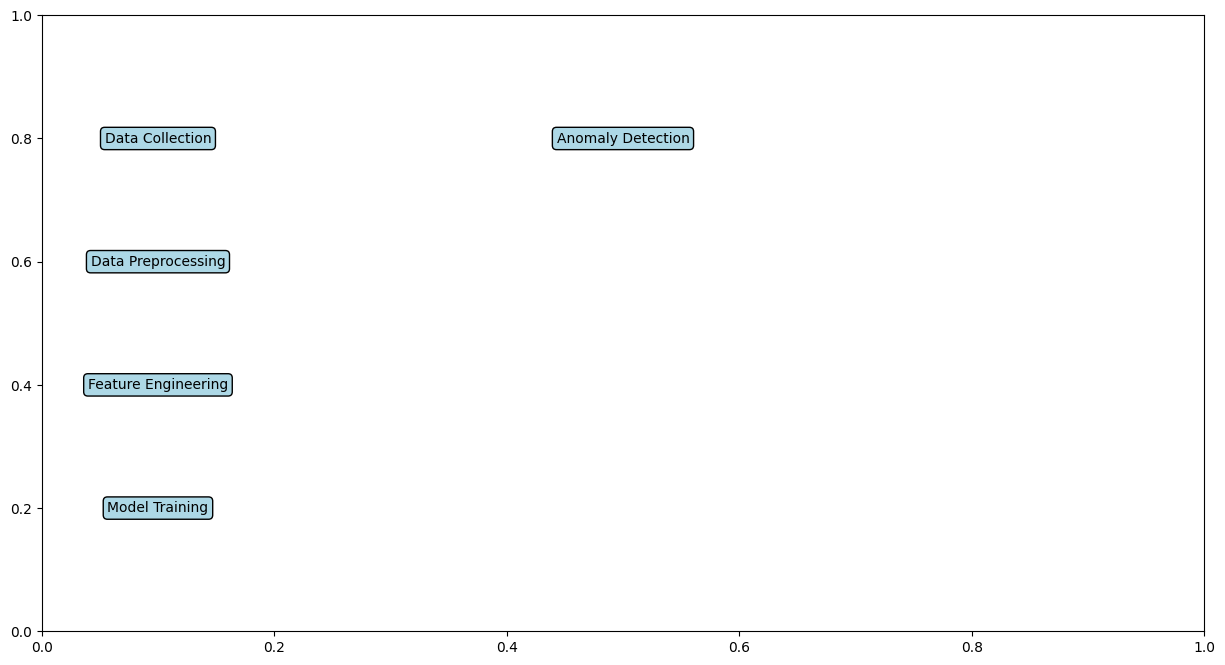

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Define style for process, decision, and output
process_style = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightblue")
decision_style = dict(boxstyle="diamond,pad=0.3", edgecolor="black", facecolor="lightgreen")
output_style = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightcoral")

# Add process boxes
ax.text(0.1, 0.8, "Data Collection", bbox=process_style, ha="center", va="center")
ax.text(0.1, 0.6, "Data Preprocessing", bbox=process_style, ha="center", va="center")
ax.text(0.1, 0.4, "Feature Engineering", bbox=process_style, ha="center", va="center")
ax.text(0.1, 0.2, "Model Training", bbox=process_style, ha="center", va="center")
ax.text(0.5, 0.8, "Anomaly Detection", bbox=process_style, ha="center", va="center")
ax.text(0.5, 0.6, "Verification and Validation", bbox=decision_style, ha="center", va="center")
ax.text(0.5, 0.4, "Integration with BMS", bbox=process_style, ha="center", va="center")
ax.text(0.5, 0.2, "Alert Generation", bbox=output_style, ha="center", va="center")
ax.text(0.9, 0.6, "Maintenance and Updates", bbox=process_style, ha="center", va="center")

# Add arrows
ax.annotate("", xy=(0.1, 0.7), xytext=(0.1, 0.75), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.1, 0.5), xytext=(0.1, 0.55), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.1, 0.3), xytext=(0.1, 0.35), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.3, 0.8), xytext=(0.2, 0.8), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.5, 0.7), xytext=(0.5, 0.75), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.5, 0.5), xytext=(0.5, 0.55), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.5, 0.3), xytext=(0.5, 0.35), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.7, 0.6), xytext=(0.6, 0.6), arrowprops=dict(arrowstyle="->"))

# Additional arrows for decisions
ax.annotate("", xy=(0.5, 0.55), xytext=(0.7, 0.55), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.7, 0.6), xytext=(0.6, 0.6), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.5, 0.5), xytext=(0.7, 0.5), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.7, 0.6), xytext=(0.9, 0.6), arrowprops=dict(arrowstyle="->"))

# Set axis limits and hide axis
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

# Show plot
plt.tight_layout()
plt.show()
